In [109]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split
import evaluation

In [2]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [3]:
df = ta.utils.dropna(data)
df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [79]:
df['pct_diff'] = (df['Close'].shift(-21) - df['Close']) / df['Close']
df['feature_sma_diff'] = df['trend_sma_fast'] - df['trend_sma_slow']
df['feature_ema_diff'] = df['trend_ema_fast'] - df['trend_ema_slow']
df['feature_diff_bbl'] = df['Close'] - df['volatility_bbl']
df['feature_diff_bbh'] = df['volatility_bbh'] - df['Close']

In [11]:
df['pct_diff']

Date
1993-01-29    0.022759
1993-02-01    0.019774
1993-02-02    0.011980
1993-02-03   -0.001395
1993-02-04    0.016667
                ...   
2020-12-24         NaN
2020-12-28         NaN
2020-12-29         NaN
2020-12-30         NaN
2020-12-31         NaN
Name: pct_diff, Length: 7033, dtype: float64

In [53]:
cols = [
    'Open',
    'Close',
    'High',
    'Low',
    'trend_macd_diff',
    'feature_sma_diff',
    'feature_ema_diff',
    'feature_diff_bbl',
    'feature_diff_bbh',
    'momentum_roc',
    'trend_sma_fast',
    'trend_sma_slow',
    'trend_ema_fast',
    'trend_ema_slow',
    'momentum_rsi',
    'trend_cci',
    'pct_diff',
]
processed = df[cols]
processed = processed[30:-60]

In [54]:
class StockDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        raw = self.df.iloc[idx].values
        if type(idx) == int:
            raw = raw.reshape(1, -1)
        data = torch.tensor(raw[:, :-1], dtype=torch.float32)
        label = torch.tensor(raw[:, -1], dtype=torch.float32)
        return data, label

In [55]:
chosen = processed
dataset = StockDataset(chosen)

In [56]:
train_data, valid_data = random_split(dataset, [len(dataset)*8//10, len(dataset) - len(dataset)*8//10])

In [57]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [58]:
class StockPredictor(nn.Module):

    def __init__(self, feature_size):
        super(StockPredictor, self).__init__()
        self.m1 = nn.Sequential(
            nn.Linear(feature_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        out = self.m1(x)
        return out

In [87]:
verbose = False

def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    train_loss, correct = 0, 0

    for batch, (data, target) in enumerate(dataloader):
        output = model(data.squeeze(1))
        loss = criterion(output, target.squeeze(1))
        train_loss += loss.item()
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        
        # debug printing
        if batch % 10 == 0 and verbose:
            print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(dataloader.dataset),
                100. * batch / len(dataloader), loss.item()
            ))

    train_loss /= len(dataloader.dataset)
    total = len(dataloader.dataset) * batch_size
    accuracy = correct / total

    print(f'Epoch: {epoch}')
    print('Training set: Average loss: {:.4f}, Accuracy {}/{} ({:.0f}%)'.format(
        train_loss, correct, total, 100. * accuracy
    ))

    return (train_loss, accuracy)

def validate(dataloader, model, criterion):
    model.eval()
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data.squeeze(1))
            valid_loss += criterion(output, target.squeeze(1)).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    valid_loss /= len(dataloader.dataset)
    total = len(dataloader.dataset) * batch_size
    accuracy = correct / total

    print('Validation set: Average loss: {:.4f}, Accuracy {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, total, 100. * accuracy
    ))

    return (valid_loss, accuracy)

def run(lr, epochs=100):
    print(f'Running for epoch={epochs}, lr={lr} ... ')

    model = StockPredictor(len(cols)-1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = StepLR(optimizer, step_size=1, gamma=0.7, verbose=True)

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    for t in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, t)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        valid_loss, valid_accuracy = validate(valid_loader, model, criterion) 
        valid_losses.append(valid_loss)
        valid_acc.append(valid_accuracy)

#         scheduler.step()

    print('[done]')
    return (model, train_losses, valid_losses, train_acc, valid_acc)

In [88]:
model, train_losses, valid_losses, train_accs, valid_accs = run(lr=0.0001)

Running for epoch=100, lr=0.0001 ... 


/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results d

Epoch: 0
Training set: Average loss: 0.0166, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0007, Accuracy 32/22224 (0%)

Epoch: 1
Training set: Average loss: 0.0145, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0031, Accuracy 32/22224 (0%)

Epoch: 2
Training set: Average loss: 0.0021, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0012, Accuracy 32/22224 (0%)

Epoch: 3
Training set: Average loss: 0.0059, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0029, Accuracy 32/22224 (0%)

Epoch: 4
Training set: Average loss: 0.0023, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0008, Accuracy 32/22224 (0%)

Epoch: 5
Training set: Average loss: 0.0087, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0006, Accuracy 32/22224 (0%)

Epoch: 6
Training set: Average loss: 0.0015, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0012, Accuracy 32/22224 (0%)

Epoch: 7
Training set: Average loss: 0.0072, Accuracy 128/88864 (0%)
Validation set

Epoch: 63
Training set: Average loss: 0.0008, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0002, Accuracy 32/22224 (0%)

Epoch: 64
Training set: Average loss: 0.0003, Accuracy 114/88864 (0%)
Validation set: Average loss: 0.0003, Accuracy 29/22224 (0%)

Epoch: 65
Training set: Average loss: 0.0004, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0012, Accuracy 32/22224 (0%)

Epoch: 66
Training set: Average loss: 0.0008, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0002, Accuracy 32/22224 (0%)

Epoch: 67
Training set: Average loss: 0.0009, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0128, Accuracy 32/22224 (0%)

Epoch: 68
Training set: Average loss: 0.0007, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0002, Accuracy 32/22224 (0%)

Epoch: 69
Training set: Average loss: 0.0015, Accuracy 128/88864 (0%)
Validation set: Average loss: 0.0011, Accuracy 32/22224 (0%)

Epoch: 70
Training set: Average loss: 0.0004, Accuracy 128/88864 (0%)
Valida

In [127]:
torch.save(model.state_dict(), 'models/ff1')

# Load and Evaluate Model

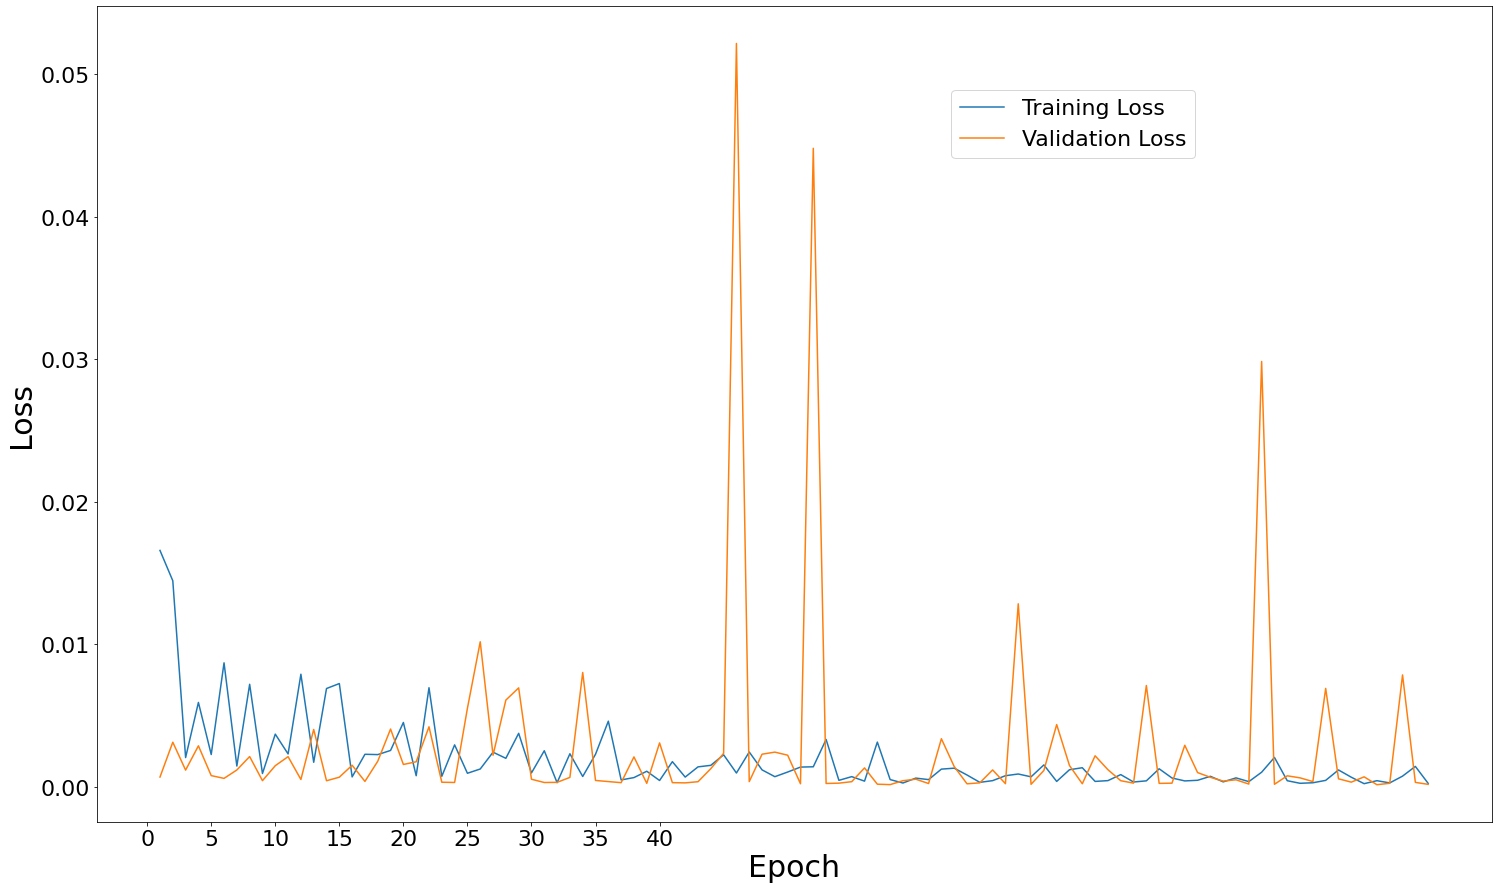

In [128]:
plt.figure(figsize=(25,15))

epoches = list(range(1,len(train_losses)+1))
plt.plot(epoches, train_losses, label='Training Loss')
plt.plot(epoches, valid_losses, label='Validation Loss')

plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0.8), fontsize=22)
plt.xticks(range(0,41,5), fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('Loss', fontsize=30)
plt.show()

In [90]:
pred = model(valid_data[:][0])
pred = pred.detach().numpy().squeeze(1)
pred.shape

(1389,)

In [93]:
final = df[-len(pred)-60:][['Open', 'High', 'Low', 'Close', 'Volume']]
final

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-02,181.952220,183.155679,181.757542,182.677841,86900900
2015-04-06,181.730973,184.456453,181.589400,183.907822,114368200
2015-04-07,183.934384,184.730784,183.385753,183.421143,81236300
2015-04-08,183.660044,184.509536,183.244142,184.040543,89351900
2015-04-09,183.863566,185.102414,183.341481,184.854645,85548900
...,...,...,...,...,...
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400
2020-12-29,370.188721,370.376883,367.237579,367.861481,53680500


In [94]:
pd.DataFrame(pred).describe()

,0
count,1389.000000
mean,-0.007975
std,0.019824
min,-0.085135
25%,-0.020147
50%,-0.005879
75%,0.005973
max,0.047442


{'whiskers': [<matplotlib.lines.Line2D at 0x133e2bb50>,
 'caps': [<matplotlib.lines.Line2D at 0x133e382b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x133e2b910>],
 'medians': [<matplotlib.lines.Line2D at 0x133e389d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x133e38d60>],
 'means': []}

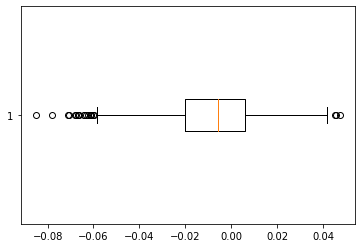

In [112]:
plt.boxplot(pred, vert=False)

In [129]:
actions = []
for change in pred:
    if change > -0.005:
        actions.append('B')
    elif change < -0.02:
        actions.append('S')
    else:
        actions.append('H')
actions.extend((['H'] * 60))
final['action'] = actions
ff_perf = evaluation.eval(final)

Performance: 36.74%


In [130]:
ff_perf.to_csv('evals/ff.csv')